# Phishing Website Detection using Neural Network
The aim of the experiments conducted in this notebook is to give an idea of how modern _phishing website attacks_ can be prevented using machine learning. To do this, we are going to use the [Phishing Websites' Dataset](https://archive.ics.uci.edu/ml/datasets/phishing+websites). 

Initially URLs from the dataset were broken down to numerical values using the file "Feature Extraction" which classifies and assigns values based on the research performed during the Capstone Project. Once that was done, every result was stored in a CSV file to be used here in this notebook.

We will start off the experiments by importing the initial set of Python modules.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Filter the uneccesary warnings
import warnings
warnings.filterwarnings("ignore")

# Import pandas and numpy
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import io
df = pd.read_csv('/content/drive/MyDrive/csv_result-Phishing_features (1).csv')

### Data loading and basic display

In [3]:
df.head()

,id,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1,1


In [4]:
y = df['Result']

In [5]:
y=y.replace(-1,0)
y

0        0
1        0
2        0
3        0
4        1
        ..
11050    1
11051    0
11052    0
11053    0
11054    0
Name: Result, Length: 11055, dtype: int64

In [6]:
X = df.iloc[:,1:31]

In [7]:
X.head()  

,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
0,-1,1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,0,1,1,1,1,-1,-1,-1,-1,1,1,-1
1,1,1,1,1,1,-1,0,1,-1,1,1,-1,1,0,-1,-1,1,1,0,1,1,1,1,-1,-1,0,-1,1,1,1
2,1,0,1,1,1,-1,-1,-1,-1,1,1,-1,1,0,-1,-1,-1,-1,0,1,1,1,1,1,-1,1,-1,1,0,-1
3,1,0,1,1,1,-1,-1,-1,1,1,1,-1,-1,0,0,-1,1,1,0,1,1,1,1,-1,-1,1,-1,1,-1,1
4,1,0,-1,1,1,-1,1,1,-1,1,1,1,1,0,0,-1,1,1,0,-1,1,-1,1,-1,-1,0,-1,1,1,1


### Inspecting data dimensions and column names

In [8]:
# Data dimension
X.shape

(11055, 30)

In [9]:
# Data columns
X.columns

Index(['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report'],
      dtype='object')

### Finding out the distribution of the class labels and preparing a report

In [10]:
from collections import Counter

classes = Counter(df['Result'].values)
classes.most_common()

[(1, 6157), (-1, 4898)]

In [11]:
class_dist = pd.DataFrame(classes.most_common(), columns=['Class', 'Num_Observations'])
class_dist

,Class,Num_Observations
0,1,6157
1,-1,4898


### Preparing a basic bar plot of the distribution of the class labels

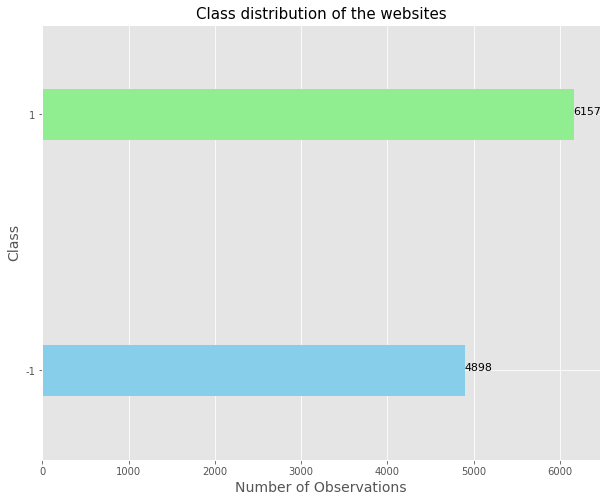

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

subplot = class_dist.groupby('Class')['Num_Observations'].sum().plot(kind='barh', width=0.2, figsize=(10,8),color=('skyblue','lightgreen'))

subplot.set_title('Class distribution of the websites', fontsize = 15)
subplot.set_xlabel('Number of Observations', fontsize = 14)
subplot.set_ylabel('Class', fontsize = 14)

for i in subplot.patches:
    subplot.text(i.get_width()+0.1, i.get_y()+0.1, \
                 str(i.get_width()), fontsize=11)

### Finding out the summary statistics from the data

In [13]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
having_IP_Address,11055.0,0.313795,0.949534,-1.0,-1.0,1.0,1.0,1.0
URL_Length,11055.0,-0.633198,0.766095,-1.0,-1.0,-1.0,-1.0,1.0
Shortining_Service,11055.0,0.738761,0.673998,-1.0,1.0,1.0,1.0,1.0
having_At_Symbol,11055.0,0.700588,0.713598,-1.0,1.0,1.0,1.0,1.0
double_slash_redirecting,11055.0,0.741474,0.671011,-1.0,1.0,1.0,1.0,1.0
Prefix_Suffix,11055.0,-0.734962,0.678139,-1.0,-1.0,-1.0,-1.0,1.0
having_Sub_Domain,11055.0,0.063953,0.817518,-1.0,-1.0,0.0,1.0,1.0
SSLfinal_State,11055.0,0.250927,0.911892,-1.0,-1.0,1.0,1.0,1.0
Domain_registeration_length,11055.0,-0.336771,0.941629,-1.0,-1.0,-1.0,1.0,1.0
Favicon,11055.0,0.628584,0.777777,-1.0,1.0,1.0,1.0,1.0


### Finding out the basic information of the columns present in the dataset

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IP_Address            11055 non-null  int64
 1   URL_Length                   11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  i

### Data splitting

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

### Defining an EarlyStopping callback

In [16]:
from keras import callbacks

es_cb = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=5)

## Trying to improve the predictive performance with Neural Networks

### Model-1 with SGD Optimizer

In [17]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_sgd1 = model.fit(X_train, y_train, epochs=15,batch_size=1,validation_data=(X_val, y_val),callbacks=[es_cb])
model.evaluate(X_test, y_test)

Epoch 1/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.2194 - accuracy: 0.9152 - val_loss: 0.1657 - val_accuracy: 0.9313
Epoch 2/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1595 - accuracy: 0.9381 - val_loss: 0.1517 - val_accuracy: 0.9394
Epoch 3/15
4962/4962 [==============================] - 13s 3ms/step - loss: 0.1380 - accuracy: 0.9424 - val_loss: 0.1514 - val_accuracy: 0.9403
Epoch 4/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1195 - accuracy: 0.9482 - val_loss: 0.1306 - val_accuracy: 0.9464
Epoch 5/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.1121 - accuracy: 0.9534 - val_loss: 0.1249 - val_accuracy: 0.9403
Epoch 6/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1019 - accuracy: 0.9591 - val_loss: 0.1196 - val_accuracy: 0.9497
Epoch 7/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.0921 - accuracy: 0.9625 - val_loss: 0.1110 - val_ac

[0.14061056077480316, 0.9490271210670471]

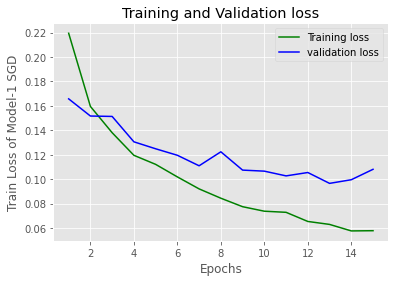

In [18]:
loss_train = history_sgd1.history['loss']
loss_val = history_sgd1.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss of Model-1 SGD')
plt.legend()
plt.show()

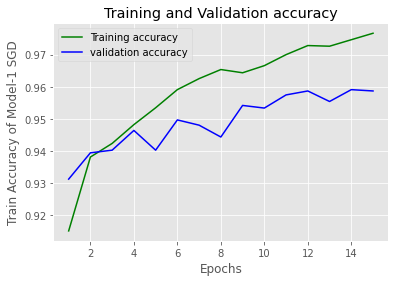

In [19]:
acc_train_sgd1 = history_sgd1.history['accuracy']
acc_val_sgd1 = history_sgd1.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, acc_train_sgd1, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_sgd1, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy of Model-1 SGD')
plt.legend()
plt.show()

### Model-1 with RMSProp Optimizer

In [23]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_rmsprop1 = model.fit(X_train, y_train, epochs=15,batch_size=1,validation_data=(X_val, y_val),callbacks=[es_cb])
model.evaluate(X_test, y_test)

Epoch 1/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3370 - accuracy: 0.9160 - val_loss: 0.2055 - val_accuracy: 0.9366
Epoch 2/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3275 - accuracy: 0.9242 - val_loss: 0.2864 - val_accuracy: 0.9210
Epoch 3/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3175 - accuracy: 0.9285 - val_loss: 0.2766 - val_accuracy: 0.9407
Epoch 4/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3303 - accuracy: 0.9309 - val_loss: 0.1875 - val_accuracy: 0.9218
Epoch 5/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.2989 - accuracy: 0.9369 - val_loss: 0.2636 - val_accuracy: 0.9386
Epoch 6/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.2878 - accuracy: 0.9349 - val_loss: 0.3810 - val_accuracy: 0.9407
Epoch 7/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.2811 - accuracy: 0.9395 - val_loss: 0.4650 - val_ac

[0.6433442831039429, 0.9424499869346619]

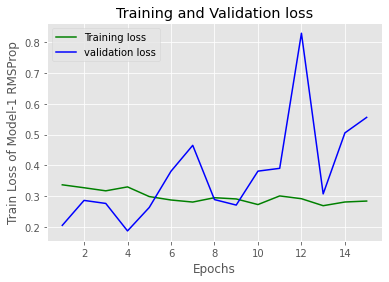

In [24]:
loss_train = history_rmsprop1.history['loss']
loss_val = history_rmsprop1.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss of Model-1 RMSProp')
plt.legend()
plt.show()

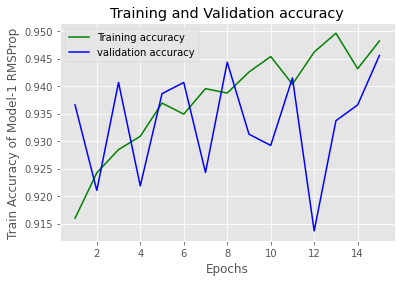

In [25]:
acc_train_rmsprop1 = history_rmsprop1.history['accuracy']
acc_val_rmsprop1 = history_rmsprop1.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, acc_train_rmsprop1, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_rmsprop1, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy of Model-1 RMSProp')
plt.legend()
plt.show()

### Model-1 with Adam Optimizer

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_adam1 = model.fit(X_train, y_train, epochs=15,batch_size=1,validation_data=(X_val, y_val),callbacks=[es_cb])
model.evaluate(X_test, y_test)

Epoch 1/15
4962/4962 [==============================] - 12s 3ms/step - loss: 0.2212 - accuracy: 0.9150 - val_loss: 0.1601 - val_accuracy: 0.9374
Epoch 2/15
4962/4962 [==============================] - 13s 3ms/step - loss: 0.1755 - accuracy: 0.9361 - val_loss: 0.2356 - val_accuracy: 0.9018
Epoch 3/15
4962/4962 [==============================] - 12s 3ms/step - loss: 0.1537 - accuracy: 0.9391 - val_loss: 0.2069 - val_accuracy: 0.9317
Epoch 4/15
4962/4962 [==============================] - 12s 3ms/step - loss: 0.1432 - accuracy: 0.9430 - val_loss: 0.1898 - val_accuracy: 0.9133
Epoch 5/15
4962/4962 [==============================] - 13s 3ms/step - loss: 0.1447 - accuracy: 0.9484 - val_loss: 0.1312 - val_accuracy: 0.9489
Epoch 6/15
4962/4962 [==============================] - 13s 3ms/step - loss: 0.1213 - accuracy: 0.9506 - val_loss: 0.1412 - val_accuracy: 0.9411
Epoch 7/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1212 - accuracy: 0.9496 - val_loss: 0.1229 - val_ac

[0.22703182697296143, 0.9427240490913391]

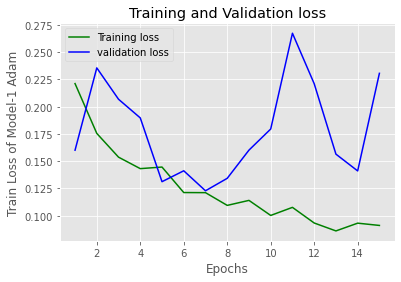

In [29]:
loss_train = history_adam1.history['loss']
loss_val = history_adam1.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss of Model-1 Adam')
plt.legend()
plt.show()

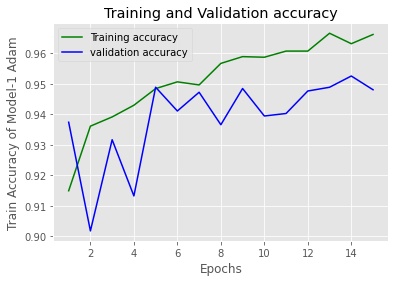

In [30]:
acc_train_adam1 = history_adam1.history['accuracy']
acc_val_adam1 = history_adam1.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, acc_train_adam1, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_adam1, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy of Model-1 Adam')
plt.legend()
plt.show()

### Comparision between Optimizer for Model-1

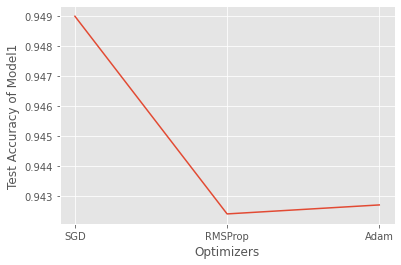

In [32]:
l=[0.9490,0.9424,0.9427]
l1 = ['SGD','RMSProp','Adam']
import matplotlib.pyplot as plt
plt.ylabel('Test Accuracy of Model1')
plt.xlabel('Optimizers')
plt.plot(l1,l)

### Model-2 with Adam Optimizer
### Here in Model-2, as we are increasing the number of neurons, we are also using dropout to overcome overfitting

In [35]:
import tensorflow as tf

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(1024, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_adam2 = model1.fit(X_train, y_train, epochs=15,batch_size=1,validation_data=(X_val, y_val),callbacks=[es_cb])
model1.evaluate(X_test, y_test)

Epoch 1/15
4962/4962 [==============================] - 13s 3ms/step - loss: 0.2320 - accuracy: 0.9135 - val_loss: 0.2864 - val_accuracy: 0.9218
Epoch 2/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1911 - accuracy: 0.9262 - val_loss: 0.1664 - val_accuracy: 0.9349
Epoch 3/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1762 - accuracy: 0.9377 - val_loss: 0.4023 - val_accuracy: 0.8588
Epoch 4/15
4962/4962 [==============================] - 13s 3ms/step - loss: 0.1620 - accuracy: 0.9379 - val_loss: 0.1845 - val_accuracy: 0.9349
Epoch 5/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1529 - accuracy: 0.9395 - val_loss: 0.1974 - val_accuracy: 0.9439
Epoch 6/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1469 - accuracy: 0.9434 - val_loss: 0.1582 - val_accuracy: 0.9345
Epoch 7/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1474 - accuracy: 0.9450 - val_loss: 0.1633 - val_ac

[0.21057496964931488, 0.944368302822113]

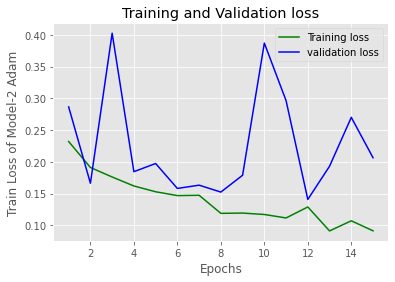

In [36]:
loss_train = history_adam2.history['loss']
loss_val = history_adam2.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss of Model-2 Adam')
plt.legend()
plt.show()

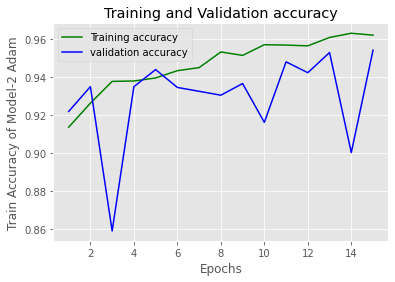

In [37]:
acc_train_adam2 = history_adam2.history['accuracy']
acc_val_adam2 = history_adam2.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, acc_train_adam2, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_adam2, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy of Model-2 Adam')
plt.legend()
plt.show()

### Model-2 with RMSProp Optimizer

In [43]:
import tensorflow as tf

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(1024, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_rmsprop2 = model1.fit(X_train, y_train, epochs=15,batch_size=1,validation_data=(X_val, y_val),callbacks=[es_cb])
model1.evaluate(X_test, y_test)

Epoch 1/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3828 - accuracy: 0.9107 - val_loss: 0.2814 - val_accuracy: 0.9247
Epoch 2/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3539 - accuracy: 0.9254 - val_loss: 0.4814 - val_accuracy: 0.9255
Epoch 3/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3539 - accuracy: 0.9301 - val_loss: 0.3130 - val_accuracy: 0.9341
Epoch 4/15
4962/4962 [==============================] - 15s 3ms/step - loss: 0.3460 - accuracy: 0.9323 - val_loss: 0.3130 - val_accuracy: 0.8932
Epoch 5/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3474 - accuracy: 0.9375 - val_loss: 0.4517 - val_accuracy: 0.9337
Epoch 6/15
4962/4962 [==============================] - 15s 3ms/step - loss: 0.3224 - accuracy: 0.9395 - val_loss: 0.3024 - val_accuracy: 0.9239
Epoch 7/15
4962/4962 [==============================] - 14s 3ms/step - loss: 0.3358 - accuracy: 0.9391 - val_loss: 0.6056 - val_ac

[0.3496992588043213, 0.9350507259368896]

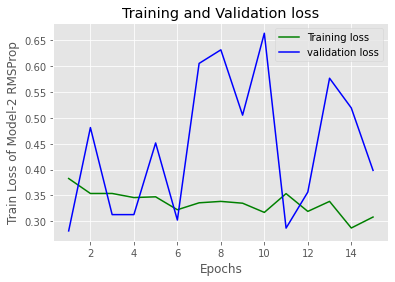

In [44]:
loss_train = history_rmsprop2.history['loss']
loss_val = history_rmsprop2.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss of Model-2 RMSProp')
plt.legend()
plt.show()

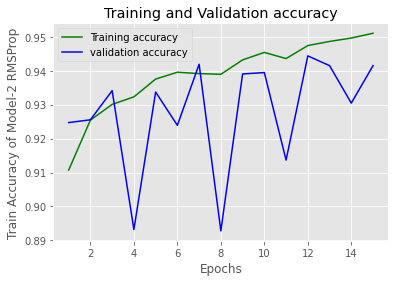

In [45]:
acc_train_rmsprop2 = history_rmsprop2.history['accuracy']
acc_val_rmsprop2 = history_rmsprop2.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, acc_train_rmsprop2, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_rmsprop2, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy of Model-2 RMSProp')
plt.legend()
plt.show()

### Model-2 with SGD Optimizer

In [47]:
import tensorflow as tf

model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dense(1024, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
model1.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_sgd2 = model1.fit(X_train, y_train, epochs=15,batch_size=1,validation_data=(X_val, y_val),callbacks=[es_cb])
model1.evaluate(X_test, y_test)

Epoch 1/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.2239 - accuracy: 0.9109 - val_loss: 0.1706 - val_accuracy: 0.9300
Epoch 2/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1589 - accuracy: 0.9351 - val_loss: 0.1475 - val_accuracy: 0.9411
Epoch 3/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1357 - accuracy: 0.9446 - val_loss: 0.1412 - val_accuracy: 0.9411
Epoch 4/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1191 - accuracy: 0.9538 - val_loss: 0.1596 - val_accuracy: 0.9358
Epoch 5/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1094 - accuracy: 0.9536 - val_loss: 0.1222 - val_accuracy: 0.9521
Epoch 6/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.1007 - accuracy: 0.9567 - val_loss: 0.1161 - val_accuracy: 0.9472
Epoch 7/15
4962/4962 [==============================] - 12s 2ms/step - loss: 0.0926 - accuracy: 0.9641 - val_loss: 0.1157 - val_ac

[0.14907461404800415, 0.9479309320449829]

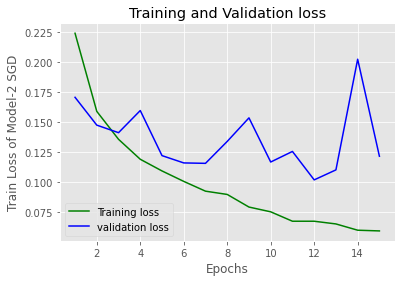

In [48]:
loss_train = history_sgd2.history['loss']
loss_val = history_sgd2.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Train Loss of Model-2 SGD')
plt.legend()
plt.show()

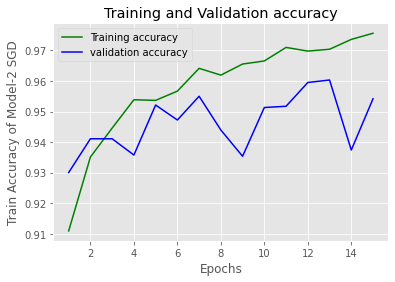

In [49]:
acc_train_sgd2 = history_sgd2.history['accuracy']
acc_val_sgd2 = history_sgd2.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, acc_train_sgd2, 'g', label='Training accuracy')
plt.plot(epochs, acc_val_sgd2, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy of Model-2 SGD')
plt.legend()
plt.show()

### Comparision between Optimizers for Model-2 

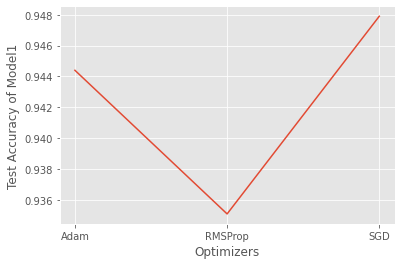

In [51]:
l=[0.9444,0.9351,0.9479]
l1 = ['Adam','RMSProp','SGD']
import matplotlib.pyplot as plt
plt.ylabel('Test Accuracy of Model1')
plt.xlabel('Optimizers')
plt.plot(l1,l)

### Comparision with Adam Optimizer for both models

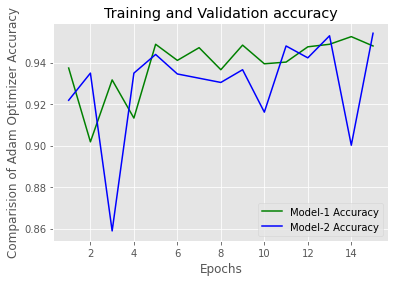

In [52]:
epochs = range(1,16)
plt.plot(epochs, acc_val_adam1, 'g', label='Model-1 Accuracy')
plt.plot(epochs, acc_val_adam2, 'b', label='Model-2 Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Comparision of Adam Optimizer Accuracy')
plt.legend()
plt.show()

### Comparision with RMSProp Optimizer for both models

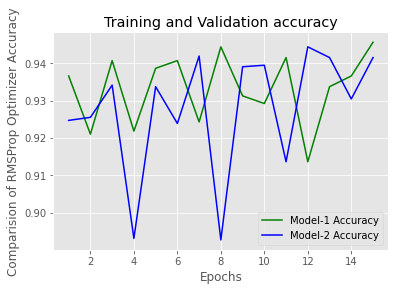

In [53]:
epochs = range(1,16)
plt.plot(epochs, acc_val_rmsprop1, 'g', label='Model-1 Accuracy')
plt.plot(epochs, acc_val_rmsprop2, 'b', label='Model-2 Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Comparision of RMSProp Optimizer Accuracy')
plt.legend()
plt.show()

### Comparision with SGD Optimizer for both models

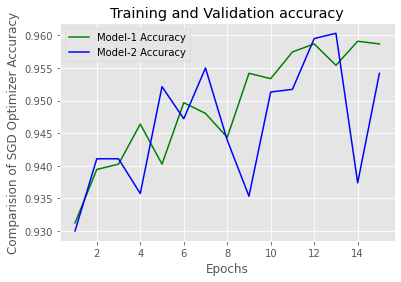

In [54]:
epochs = range(1,16)
plt.plot(epochs, acc_val_sgd1, 'g', label='Model-1 Accuracy')
plt.plot(epochs, acc_val_sgd2, 'b', label='Model-2 Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Comparision of SGD Optimizer Accuracy')
plt.legend()
plt.show()

## Model Enhancement with TDLHBA hyperparameters and visualization

`TDLHBA` is technique introduced [in this paper](https://dl.acm.org/citation.cfm?id=3227655). We will use hyperparameter values as presented in the paper to see the performance enhancement of the model. 

In [55]:
# Imports
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import *

model_TDLHBA = Sequential()

model_TDLHBA.add(Dense(40, activation='relu',
          kernel_initializer='uniform',input_dim=30))
model_TDLHBA.add(Dense(30, activation='relu',
          kernel_initializer='uniform'))
model_TDLHBA.add(Dense(1,  activation='sigmoid', 
          kernel_initializer='uniform'))

adam = Adam(lr=0.0017470)
model_TDLHBA.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [67]:
history_TDLHBA = model_TDLHBA.fit(X_train, y_train, batch_size=1, epochs=30, callbacks=[es_cb])

scores = model_TDLHBA.evaluate(X_test, y_test)
print('\nAccuracy score of the Neural Network with TDLHBA hyperparameter settings {0:.2f}%'.format(scores[1]*100))

Epoch 1/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0418 - accuracy: 0.9833
Epoch 2/30
4962/4962 [==============================] - 12s 2ms/step - loss: 0.0370 - accuracy: 0.9841
Epoch 3/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0476 - accuracy: 0.9819
Epoch 4/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0425 - accuracy: 0.9819
Epoch 5/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0419 - accuracy: 0.9843
Epoch 6/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0392 - accuracy: 0.9829
Epoch 7/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0346 - accuracy: 0.9849
Epoch 8/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0450 - accuracy: 0.9835
Epoch 9/30
4962/4962 [==============================] - 13s 3ms/step - loss: 0.0351 - accuracy: 0.9855
Epoch 10/30
4962/4962 [==============================] - 13s 3ms/step - l

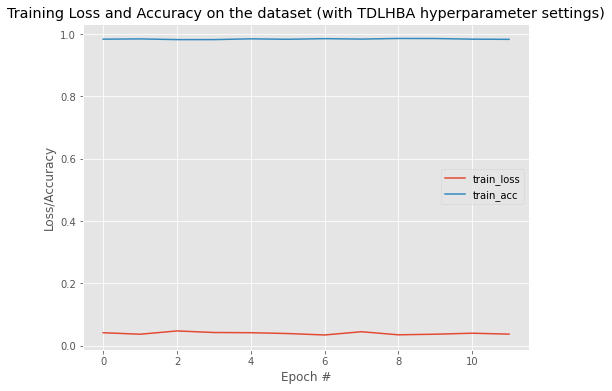

In [69]:
N = 12

plt.figure(figsize=(8,6))
plt.plot(np.arange(0, N), history_TDLHBA.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history_TDLHBA.history["accuracy"], label="train_acc")

plt.title("Training Loss and Accuracy on the dataset (with TDLHBA hyperparameter settings)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="middle")
plt.show()